## Projet DataMining: Prédiction de prix d'appartements en Ile de France



Il s'agit ici d'un problème de régression.
Nous souhaitons prédire les prix des logements en Ile-de-France à partir de plusieurs variables (surface, étage, charges, date de construction...).

Nos données ont été obtenues grâce à la technique de scraping, nous avons programé un scraper python qui a récupéré les annonces sur le site de l'agence Foncia. Le code et les résultats du scraper sont disponibles sur le repository Github.

Après le nettoyage des données, nous avons utilisé plusieurs modèles : RandomForestRegressor, SVR et LinearRegressor

Pour chaque modèle, les étapes sont les mêmes:

> 1. Décomposer le dataset en base d'apprentissage et base de test
> 2. Utiliser la base d'apprentissage pour construire un modèle de prédiction
> 3. Evaluer le modèle en utilisant la base de test

Ouverture du dataframe construit à partir du scrapping des sites Foncia

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline
pd.options.mode.chained_assignment = None 

df = pd.read_csv("scrapping_results_final.csv")
df.head()


,Unnamed: 0,Unnamed: 0.1,categorie,charges_annuelles,copropriete_en_difficulte,date_de_construction,etage,mode_chauffage,nature_chauffage,nb_etages,nb_lots,postal_code,price,surface,Unnamed: 0.2,mode_chauffage.1,nb_chambres,nb_piece
0,0,0,Ancien,240 €,non,1890.0,7,Individuel,Electrique,7.0,23.0,paris-75010,\n ...,7 m²,0,Individuel,1.0,1.0
1,1,1,Ancien,NaN,non,1905.0,6,NaN,NaN,6.0,19.0,paris-75017,\n ...,6 m²,1,NaN,NaN,1.0
2,2,2,Ancien,132 €,non,1800.0,6,Sans,NaN,6.0,31.0,paris-75003,\n ...,5.69 m²,2,Sans,1.0,1.0
3,3,3,NaN,240 €,non,1900.0,6,Individuel,Gaz,6.0,28.0,paris-75012,\n ...,7 m²,3,Individuel,1.0,1.0
4,4,4,Ancien,144 €,non,1900.0,7,Individuel,Electrique,7.0,50.0,paris-75017,\n ...,7.8 m²,4,Individuel,NaN,1.0


## I. Nettoyage de données


La première étape consiste à nettoyer le dataframe pour avoir des données lisibles et au bon format

In [2]:
df.drop(["Unnamed: 0",'Unnamed: 0.1','Unnamed: 0.2','mode_chauffage.1'], axis=1, inplace=True)

In [3]:
df['charges_annuelles'] = df['charges_annuelles'].str.replace('€', '')
df['charges_annuelles'] = df['charges_annuelles'].str.replace(' ', '')

In [4]:
def convert_int(x):
    if pd.notnull(x):
        return int(x)

df['date_de_construction'] = df['date_de_construction'].apply(lambda x: convert_int(x))
df['etage'] = df['etage'].apply(lambda x: 0 if x=="RDC" else x)
df['etage'] = df['etage'].apply(lambda x: convert_int(x))
df['nb_etages'] = df['nb_etages'].apply(lambda x: convert_int(x))
df['postal_code'] = df['postal_code'].apply(lambda x: x[-5:-1]+x[-1])
df['price'] = df['price'].str.replace(' ','')
df['price'] = df['price'].str.replace('\n','')
df['price'] = df['price'].str.replace('€','')
df['price'] = df['price'].apply(lambda x: convert_int(x))
df['surface'] = df['surface'].str.replace('m²','')
df['surface'] = df['surface'].apply(lambda x: float(x))
df['departement']=df['postal_code'].apply(lambda x: str(x)[0:2])
df['departement'] = df['departement'].apply(lambda x: convert_int(x))

In [5]:
df.head()

,categorie,charges_annuelles,copropriete_en_difficulte,date_de_construction,etage,mode_chauffage,nature_chauffage,nb_etages,nb_lots,postal_code,price,surface,nb_chambres,nb_piece,departement
0,Ancien,240,non,1890.0,7.0,Individuel,Electrique,7.0,23.0,75010,50000.0,7.00,1.0,1.0,75
1,Ancien,NaN,non,1905.0,6.0,NaN,NaN,6.0,19.0,75017,57000.0,6.00,NaN,1.0,75
2,Ancien,132,non,1800.0,6.0,Sans,NaN,6.0,31.0,75003,60000.0,5.69,1.0,1.0,75
3,NaN,240,non,1900.0,6.0,Individuel,Gaz,6.0,28.0,75012,65000.0,7.00,1.0,1.0,75
4,Ancien,144,non,1900.0,7.0,Individuel,Electrique,7.0,50.0,75017,70000.0,7.80,NaN,1.0,75


## II. Interprétation des variables

### 1. Remplacement des valeurs nulles

Certaines valeurs sont manquantes. Il est nécessaire de les remplacer par des valeurs cohérentes afin de pouvoir ensuite créer un modèle. Dans un premier temps, ces valeurs ont été remplacée par la médiane de chacune des caractéristiques. 

In [6]:
df['charges_annuelles'].fillna(df['charges_annuelles'].median(), inplace=True)
df['date_de_construction'].fillna(df['date_de_construction'].median(), inplace=True)
df['nb_etages'].fillna(df['nb_etages'].median(), inplace=True)
df['nb_lots'].fillna(df['nb_lots'].median(), inplace=True)
df['etage'].fillna(df['etage'].median(), inplace=True)
df['nb_chambres'].fillna(df['nb_chambres'].median(), inplace=True)
df['nb_piece'].fillna(df['nb_piece'].median(), inplace=True)
df['categorie'].fillna('Ancien', inplace=True)
df['copropriete_en_difficulte'].fillna('non', inplace=True)

Le tableau ci-dessous est construit afin de vérifier si toutes les valeurs nulles ont bien été remplacées.

In [7]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
nature_chauffage,260,0.202966
mode_chauffage,202,0.157689
surface,71,0.055425
price,46,0.035909
departement,0,0.000000
nb_piece,0,0.000000
nb_chambres,0,0.000000
postal_code,0,0.000000
nb_lots,0,0.000000
nb_etages,0,0.000000


Le prix étant la variable à prédire, les lignes pour lesquelles le prix n'a pas été donné doivent être supprimées. Par ailleurs, comme montré plus tard, la surface impacte fortement le prix. Il est donc préférable de supprimer les lignes où la valeur de la surface est manquante afin de ne pas fausser les résultats.

In [8]:
df = df[pd.notnull(df['price'])]
df = df[pd.notnull(df['surface'])]

In [9]:
df.shape

(1210, 15)

###### Nous avons donc au final un dataset contenant 1210 appartements et 15 caractéristiques

### 2. Interpretation des données

Certaines variables contiennent des valeurs équivalentes qui nécessitent d'être regroupées en une seule valeur. 

In [10]:
df['nature_chauffage'].groupby(df['nature_chauffage']).count()

nature_chauffage
Autre                                     3
Chaudières à granules                     2
Chauffage au sol Electrique               1
Chauffage au sol Fuel                     1
Chauffage au sol Gaz                     14
Electricité + Cheminée                    1
Electricité + Poêle                       2
Electricité/Bois                          2
Electrique                              443
Fuel                                     14
Fuel + Cheminée                           2
Gaz                                     397
Gaz (de ville ou Propane) + Cheminée      8
Géothermie                               24
Mixte                                     6
Par le sol                               21
Pompe à chaleur                           1
Poêle à granules                          1
Urbain                                   65
Name: nature_chauffage, dtype: int64

In [11]:
df['mode_chauffage'].groupby(df['mode_chauffage']).count()

mode_chauffage
Collectif     446
Individuel    614
Mixte           5
Sans            1
Name: mode_chauffage, dtype: int64

'Nature_chauffage' peut être regroupé en Electrique, Gaz et Autre_nature.

'Mode chauffage' peut être regroupé en Individuel, Collectif et Autre_mode. 

'Catégorie' peut être regroupé en Ancient et Récent.

In [12]:
df['nature_chauffage'][df['nature_chauffage']=='Electricité + Cheminée'] = 'Electrique'
df['nature_chauffage'][df['nature_chauffage']=='Electricité + Poêle'] = 'Electrique'
df['nature_chauffage'][df['nature_chauffage']=='Electricité/Bois'] = 'Electrique'
df['nature_chauffage'][df['nature_chauffage']=='Gaz (de ville ou Propane) + Cheminée'] = 'Gaz'
df['nature_chauffage'][(df['nature_chauffage']!= 'Electrique') & (df['nature_chauffage']!= 'Gaz')] = 'Autre_nature'
df['nature_chauffage'].groupby(df['nature_chauffage']).count()

nature_chauffage
Autre_nature    357
Electrique      448
Gaz             405
Name: nature_chauffage, dtype: int64

In [13]:
df['mode_chauffage'][(df['mode_chauffage']!= 'Individuel') & (df['mode_chauffage']!= 'Collectif')] = 'Autre_mode'
df['mode_chauffage'].groupby(df['mode_chauffage']).count()

mode_chauffage
Autre_mode    150
Collectif     446
Individuel    614
Name: mode_chauffage, dtype: int64

In [14]:
df['categorie'][df['categorie']=='Sur plan'] = 'Récent'
df['categorie'][df['categorie']=='Moins de 10 ans'] = 'Récent'
df['categorie'][df['categorie']=='Neuf'] = 'Récent'
df['categorie'].unique()

array(['Ancien', 'Récent'], dtype=object)

## III. Analyse exploratoire

### 1. Analyse de la variable à prédire

Il est important de comprendre comment varient les prix des appartements.

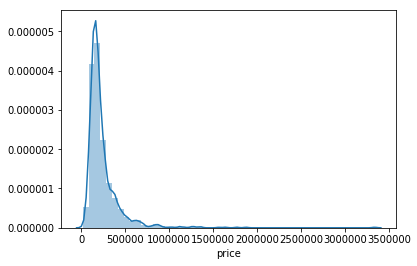

In [15]:
sns.distplot(df['price'])

On constate par ailleurs que certaines valeurs sont très écartées de la moyenne. Les algorithmes d'apprentissage risquent d'avoir plus de mal à les estimer.

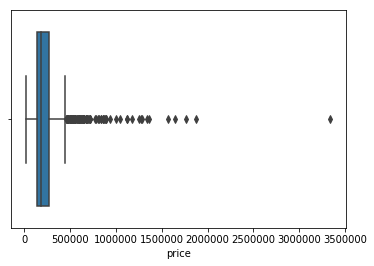

In [16]:
 ax = sns.boxplot(x=df["price"])

### 2. Analyse des caractérisques

Lorsque l'on visualise le prix moyen par mètre carré en fonction du département, on constate une forte disparité entre les prix de Paris 75 et des autres départements. Par ailleurs, l'écart type des prix à Paris est bien plus élevé qu'ailleurs. Il serait donc intéressant de segmenter par arrondissement.

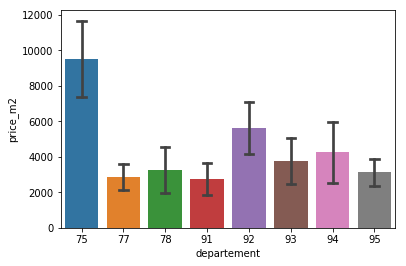

In [17]:
df['price_m2']=df['price']/df['surface']
ax = sns.barplot(df.departement, df.price_m2, ci="sd", capsize=.2)

In [18]:
df['arrondissement'] = df['postal_code'].apply(lambda x: x[-2:-1]+x[-1] if x[-5:-3]=='75' else x[-5:-3])
df['arrondissement'] = df['arrondissement'].apply(lambda x: convert_int(x))

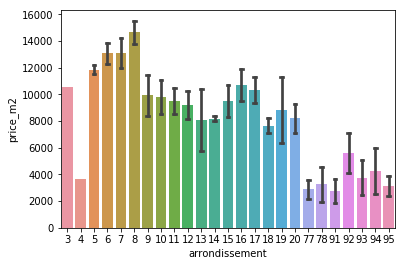

In [19]:
ax = sns.barplot(df.arrondissement, df.price_m2, ci="sd", capsize=.2)

Il semble donc que le prix soit fortement impacté par l'arrondissement mais surtout la zone (Paris/Hors Paris). Il serait donc intéressant de construire une variable zone pour prendre en compte cet aspect.

In [20]:
df['zone_paris']=1
df['zone_paris'][df['departement']!=75]=0

Il serait intéressant ensuite de visualiser l'impact de la surface sur le prix en fonction de la zone. On constate en effet grâce au graphe ci-dessous une forte corrélation.

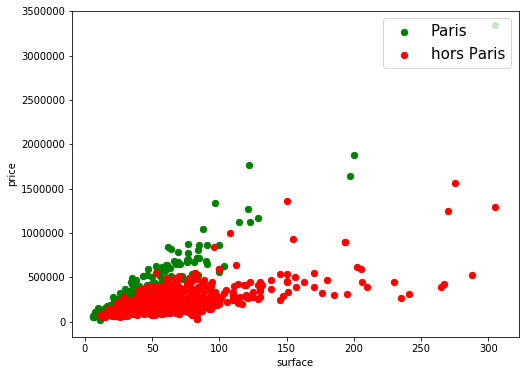

In [21]:
plt.figure(figsize=(8,6))
ax = plt.subplot()
ax.scatter(df[df['zone_paris']==1]['surface'],df[df['zone_paris']==1]['price'],c='green',s=40)
ax.scatter(df[df['zone_paris']==0]['surface'],df[df['zone_paris']==0]['price'],c='red',s=40)
ax.set_xlabel('surface')
ax.set_ylabel('price')
ax.legend(('Paris','hors Paris'),scatterpoints=1,loc='upper right',fontsize=15,)

On pourrait faire de même pour observer l'impact de l'étage sur le prix pour un appartement dans Paris et Hors Paris. Néanmoins les graphes ci-dessous sont moins concluants.

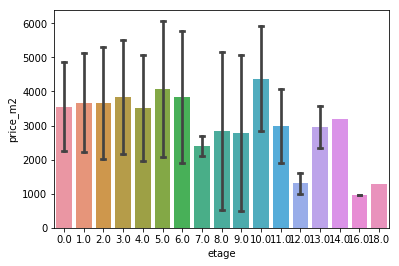

In [22]:
ax = sns.barplot(df[df['departement']!=75].etage, df.price_m2, ci="sd", capsize=.2)

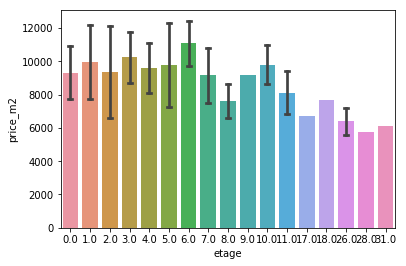

In [23]:
ax = sns.barplot(df[df['departement']==75].etage, df.price_m2, ci="sd", capsize=.2)

On peut généraliser cette approche à chacune des variables à l'aide de la matrice de corrélation ci-dessous. 

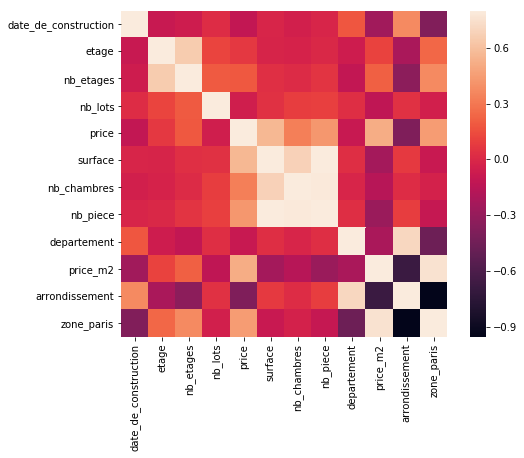

In [24]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corrmat, vmax=.8, square=True);

## IV. Premiers modèles : LinearRegression et SVR

### 1. Préparation des données
    Ces deux modèles nécessitent une préparation similaire des données.

In [25]:
import copy
df_lin = copy.copy(df)

In [26]:
df_lin.drop(['departement', 'date_de_construction', 'postal_code','arrondissement','price_m2'], axis=1, inplace=True)

In [27]:
df_lin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1210 entries, 0 to 1275
Data columns (total 13 columns):
categorie                    1210 non-null object
charges_annuelles            1210 non-null object
copropriete_en_difficulte    1210 non-null object
etage                        1210 non-null float64
mode_chauffage               1210 non-null object
nature_chauffage             1210 non-null object
nb_etages                    1210 non-null float64
nb_lots                      1210 non-null float64
price                        1210 non-null float64
surface                      1210 non-null float64
nb_chambres                  1210 non-null float64
nb_piece                     1210 non-null float64
zone_paris                   1210 non-null int64
dtypes: float64(7), int64(1), object(5)
memory usage: 132.3+ KB


In [28]:
df_lin.head()

,categorie,charges_annuelles,copropriete_en_difficulte,etage,mode_chauffage,nature_chauffage,nb_etages,nb_lots,price,surface,nb_chambres,nb_piece,zone_paris
0,Ancien,240,non,7.0,Individuel,Electrique,7.0,23.0,50000.0,7.00,1.0,1.0,1
1,Ancien,1620,non,6.0,Autre_mode,Autre_nature,6.0,19.0,57000.0,6.00,2.0,1.0,1
2,Ancien,132,non,6.0,Autre_mode,Autre_nature,6.0,31.0,60000.0,5.69,1.0,1.0,1
3,Ancien,240,non,6.0,Individuel,Gaz,6.0,28.0,65000.0,7.00,1.0,1.0,1
4,Ancien,144,non,7.0,Individuel,Electrique,7.0,50.0,70000.0,7.80,2.0,1.0,1


In [29]:
#pour les colonnes ou le type est object, on remplace les strings par des chiffres représentant une catégorie
for feature in df_lin.columns: 
    if df_lin[feature].dtype == 'object': 
        df_lin[feature] = pd.Categorical(df_lin[feature]).codes 

In [30]:
df_lin.head()

,categorie,charges_annuelles,copropriete_en_difficulte,etage,mode_chauffage,nature_chauffage,nb_etages,nb_lots,price,surface,nb_chambres,nb_piece,zone_paris
0,0,109,0,7.0,2,1,7.0,23.0,50000.0,7.00,1.0,1.0,1
1,0,0,0,6.0,0,0,6.0,19.0,57000.0,6.00,2.0,1.0,1
2,0,25,0,6.0,0,0,6.0,31.0,60000.0,5.69,1.0,1.0,1
3,0,109,0,6.0,2,2,6.0,28.0,65000.0,7.00,1.0,1.0,1
4,0,35,0,7.0,2,1,7.0,50.0,70000.0,7.80,2.0,1.0,1


In [31]:
y = df_lin['price']
X = df_lin.drop('price', axis=1)

from sklearn.preprocessing import StandardScaler
scaler_0 = StandardScaler().fit(X)
X_0 = scaler_0.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_0, y, test_size=0.3, random_state=0)

### 2. Test du modèle Linear Regression

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
lm = LinearRegression()
lm.fit(X_train, y_train)

print("Estimated intercept coefficient : ", lm.intercept_)
print("Number of coefficient : ", len(lm.coef_))
print("Score du modèle : ", lm.score(X, y))


Estimated intercept coefficient :  243079.852536
Number of coefficient :  12
Score du modèle :  -2985.10003919


Le score du modèle n'est pas excellent, mais ce n'est pas la mesure la plus significative de la qualité et la pertinence du modèle.

À partir du modèle, on peut prédire les sorties de l'ensemble Test, et puis mesure la différence entre la vérité terrain et les prédictions obtenues de manière graphique.
Ce modèle fait une erreur de 109 600€ en prédisant les prix ce qui est considérable vu le prix moyen d'un logement.

In [33]:
y_pred = lm.predict(X_test)
erreur = sqrt(mean_squared_error(y_test, y_pred))
print("Ce modèle fait une erreur de :") 
print(erreur)
print ("En pourcentage, cela fait une erreur de: ")
erreur/y.mean()

Ce modèle fait une erreur de :
114147.55269088196
En pourcentage, cela fait une erreur de: 


0.4721878055722524

Text(0,0.5,'Residuals')

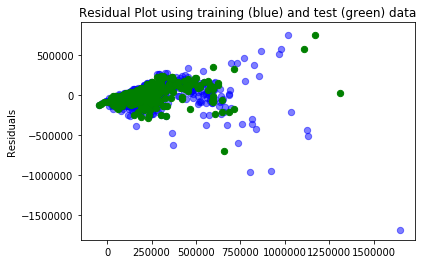

In [34]:
plt.scatter(lm.predict(X_train), lm.predict(X_train) - y_train, c='b', s=40, alpha=0.5)
plt.scatter(lm.predict(X_test), lm.predict(X_test) - y_test, c='g', s=40)
plt.hlines(y = 0, xmin=0, xmax=50)
plt.title('Residual Plot using training (blue) and test (green) data')
plt.ylabel('Residuals')

Plus les données sont proches de l'axe des abscisses, à y=0, meilleur le modèle est.

### 3. Test du modèle SVR

Nous testons le modèle SVR avec différents kernel (polynomial, rbf et linéaire), le kernel linéaire étant le plus performant nous le présentons ci dessous

In [35]:
from sklearn.svm import SVR


svr_lin = SVR( kernel='linear', C=1e3)
svr_lin.fit(X_train, y_train)
y_lin = svr_lin.predict(X_test)



In [36]:
from sklearn.metrics import r2_score,explained_variance_score,mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

m_lin= sqrt(mean_squared_error(y_test, y_lin))

r2 = r2_score(y_test, y_lin)

print("r-squared test score : " + str(r2))
print()
print("mean_squared_error : " + str(m_lin)) 



r-squared test score : 0.467872362709

mean_squared_error : 116070.78216687393


Nous obtenons un coefficient de regression faible de 47% et une erreur de 116 000 euros sur un prix moyen des logements de 240 000. On se trompe donc en moyenne de 116 000 euros sur un prix d'un logement. C'est une erreur conséquente. 

In [37]:
print ("En pourcentage, cela fait une erreur de: ")
m_lin/y.mean()

En pourcentage, cela fait une erreur de: 


0.4801435215247422

Pour améliorer l'erreur, nous décidons de supprimer les valeurs extrêmes'

In [38]:
df_lin['price'].describe()

count    1.210000e+03
mean     2.417418e+05
std      2.043881e+05
min      1.800000e+04
25%      1.407000e+05
50%      1.850000e+05
75%      2.657500e+05
max      3.340000e+06
Name: price, dtype: float64

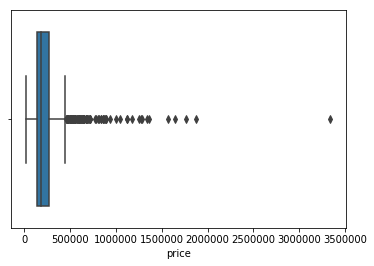

In [39]:
 ax = sns.boxplot(x= df_lin["price"])

Nous remarquons l'existance d'une valeur maximale qui se distingue des autres et qui risque d'impacter notre erreur

In [40]:
df_lin = df_lin.drop(df_lin['price'].idxmax())

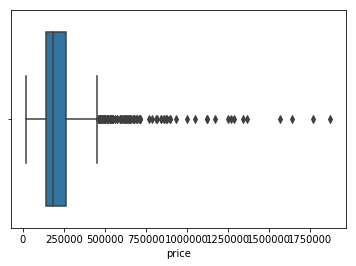

In [41]:
ax = sns.boxplot(x=df_lin["price"])

In [45]:
y = df_lin['price']
X = df_lin.drop('price', axis=1)

from sklearn.preprocessing import StandardScaler
scaler_0 = StandardScaler().fit(X)
X_0 = scaler_0.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_0, y, test_size=0.3, random_state=30)

In [46]:
svr_lin = SVR( kernel='linear', C=1e3)
svr_lin.fit(X_train, y_train)
y_lin = svr_lin.predict(X_test)

m_lin= sqrt(mean_squared_error(y_test, y_lin))
r2 = r2_score(y_test, y_lin)

print("r-squared test score : " + str(r2))
print()
print("mean_squared_error : " + str(m_lin))



r-squared test score : 0.444929707782

mean_squared_error : 150673.70409584144


Text(0,0.5,'Residuals')

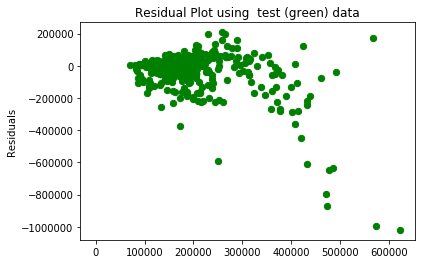

In [44]:
#plt.scatter(svr_lin.predict(X_train), svr_lin.predict(X_train) - y_train, c='b', s=40, alpha=0.5)
plt.scatter(y_lin , y_lin - y_test, c='g', s=40)
plt.hlines(y = 0, xmin=0, xmax=50)
plt.title('Residual Plot using  test (green) data')
plt.ylabel('Residuals')

Finalement, notre erreur augmente à 150 000 € qui est contrintuitif. Or ceci est du au fait que le split entre les données de test et train.
Le graphique ci-dessus représente la différence entre la vérité terrain et les prédictions. 
Ainsi, notre modèle est plus pertinent pour les logements à prix inférieur à 400 000 €.

Si on teste le modèle sur les prix inférieurs à 400 000 euros nous obtenons ceci :

In [47]:
df_lin= df_lin[df_lin['price']<400000]

In [48]:
df_lin['price'].describe()

count      1082.000000
mean     191142.988909
std       77365.137611
min       18000.000000
25%      135400.000000
50%      176000.000000
75%      231875.000000
max      399000.000000
Name: price, dtype: float64

In [49]:
y = df_lin['price']
X = df_lin.drop('price', axis=1)

from sklearn.preprocessing import StandardScaler
scaler_0 = StandardScaler().fit(X)
X_0 = scaler_0.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_0, y, test_size=0.3)

svr_lin = SVR( kernel='linear', C=1e3)
svr_lin.fit(X_train, y_train)
y_lin = svr_lin.predict(X_test)

m_lin= sqrt(mean_squared_error(y_test, y_lin))
r2 = r2_score(y_test, y_lin)

print("r-squared test score : " + str(r2))
print()
print("mean_squared_error : " + str(m_lin))



r-squared test score : 0.210842418239

mean_squared_error : 63544.449041575666


Notre erreur est donc divisé par deux et on arrive à prédire un prix avec une précision de 63 000€ dès lors que les prix sont inférieurs a 400 000€ et le prix moyen est de 191 000€. On a donc une erreur de 30%.

## V. Troisième modèle : Random Forest

### 1. Préparation des données

Lors d'une régression, il est préferable que la variable à prédire suive une loi normale. On peut donc appliquer une transformation non linéaire comme le log.

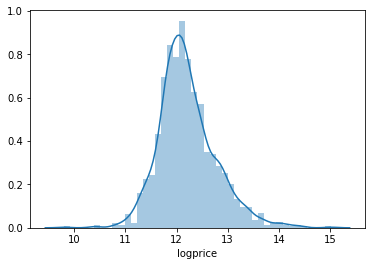

In [50]:
df['logprice'] = np.log(df['price'])
sns.distplot(df['logprice'])

Les algorithmes d'apprentissage nécessitent des variables numériques. Des 'dummies' vont donc être crées pour les variables string.

In [51]:
df = df.join(pd.get_dummies(df.categorie))
#df = df.join(pd.get_dummies(df.arrondissement))
df = df.join(pd.get_dummies(df.mode_chauffage))
df = df.rename(columns={"Autre":"Autre_mode"})
df = df.join(pd.get_dummies(df.nature_chauffage))
df = df.rename(columns={"Autre":"Autre_nature"})
df = df.join(pd.get_dummies(df.copropriete_en_difficulte))
df = df.rename(columns={"oui":"copropriete_en_difficulte"})

Certaines variables 'dummiser' expriment les mêmes informations et doivent donc être retirées.

In [52]:
df.drop(['arrondissement', 'postal_code', 'departement','categorie', 'mode_chauffage','copropriete_en_difficulte', 'nature_chauffage', 'non'], axis=1, inplace=True)

In [53]:
df.columns

Index(['charges_annuelles', 'date_de_construction', 'etage', 'nb_etages',
       'nb_lots', 'price', 'surface', 'nb_chambres', 'nb_piece', 'price_m2',
       'zone_paris', 'logprice', 'Ancien', 'Récent', 'Autre_mode', 'Collectif',
       'Individuel', 'Autre_nature', 'Electrique', 'Gaz'],
      dtype='object')

In [54]:
print(df.shape)
df.head()

(1210, 20)


,charges_annuelles,date_de_construction,etage,nb_etages,nb_lots,price,surface,nb_chambres,nb_piece,price_m2,zone_paris,logprice,Ancien,Récent,Autre_mode,Collectif,Individuel,Autre_nature,Electrique,Gaz
0,240,1890.0,7.0,7.0,23.0,50000.0,7.00,1.0,1.0,7142.857143,1,10.819778,1,0,0,0,1,0,1,0
1,1620,1905.0,6.0,6.0,19.0,57000.0,6.00,2.0,1.0,9500.000000,1,10.950807,1,0,1,0,0,1,0,0
2,132,1800.0,6.0,6.0,31.0,60000.0,5.69,1.0,1.0,10544.815466,1,11.002100,1,0,1,0,0,1,0,0
3,240,1900.0,6.0,6.0,28.0,65000.0,7.00,1.0,1.0,9285.714286,1,11.082143,1,0,0,0,1,0,0,1
4,144,1900.0,7.0,7.0,50.0,70000.0,7.80,2.0,1.0,8974.358974,1,11.156251,1,0,0,0,1,0,1,0


### 2. Test du modèle Random Forest


In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from math import sqrt

y = df.logprice
X = df.drop(["logprice","price","price_m2"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg = RandomForestRegressor(n_estimators=500)
reg.fit(X_train, y_train)
print("Le coefficient de corrélation est égal à {}".format(reg.score(X_test, y_test)))
y_pred = reg.predict(X_test)
print("Le MSE est égal à {}".format(sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))))

Le coefficient de corrélation est égal à 0.7737793757094344
Le MSE est égal à 84357.44349953909


##### On obtient un coefficient de corrélation R2 égal à 0.78 . Par ailleurs, le MSE est égal à 84 000. On se trompe donc en moyenne de 84 000€ pour chaque appartement. 

Par ailleurs, on peut observer l'impact positif d'avoir pris le log du prix comme variable à prédire. On obtient pour le modèle ci-dessous (variable = price) un MSE supérieur. 

Le paramètre random_state permet de comparer plusieurs modèles car il s'agit du même aléa utilisé. 

In [56]:
y = df.price
X = df.drop(["logprice","price","price_m2"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg = RandomForestRegressor(n_estimators=500)
reg.fit(X_train, y_train)
print("Le coefficient de corrélation est égal à {}".format(reg.score(X_test, y_test)))
y_pred = reg.predict(X_test)
print("Le MSE est égal à {}".format(sqrt(mean_squared_error(y_test, y_pred))))

Le coefficient de corrélation est égal à 0.7105343234341208
Le MSE est égal à 96154.54351530774


On peut observer ensuite l'importance de chacune des variables dans la prédiction du prix. On retrouve certaines observations faites lors de l'analyse exploratoire.

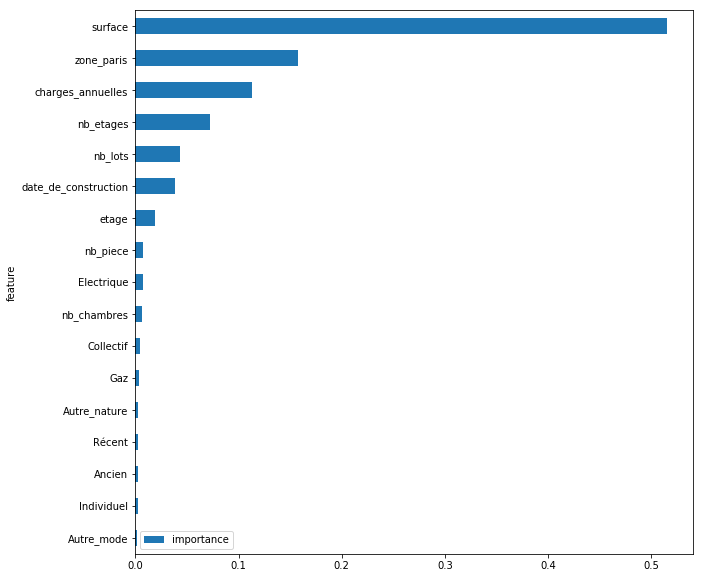

In [57]:
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = reg.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(10, 10))

Regardons plus en détail, comment se décompose le MSE par zone (Paris/Hors Paris)

In [58]:
dfx = df[df['zone_paris']==0]
y2 = dfx.logprice
X2 = dfx.drop(["logprice","price","price_m2"], axis=1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=30)
reg = RandomForestRegressor(n_estimators=500, random_state=42)
reg.fit(X2_train, y2_train)
print("Le coefficient de corrélation est égal à {}".format(reg.score(X2_test, y2_test)))

y2_pred = reg.predict(X2_test)
print("Le MSE est égal à {}".format(sqrt(mean_squared_error(np.exp(y2_test), np.exp(y2_pred)))))

Le coefficient de corrélation est égal à 0.5676808165068409
Le MSE est égal à 77209.00928792467


In [59]:
dfx = df[df['zone_paris']==1]
y2 = dfx.logprice
X2 = dfx.drop(["logprice","price","price_m2"], axis=1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=30)
reg = RandomForestRegressor(n_estimators=500, random_state=42)
reg.fit(X2_train, y2_train)
print("Le coefficient de corrélation est égal à {}".format(reg.score(X2_test, y2_test)))

y2_pred = reg.predict(X2_test)
print("Le MSE est égal à {}".format(sqrt(mean_squared_error(np.exp(y2_test), np.exp(y2_pred)))))

Le coefficient de corrélation est égal à 0.930143570073119
Le MSE est égal à 167694.97378860542


On observe que l'erreur de prédiction pour la zone Paris est très élevée comparée à celle Hors Paris.

Néanmoins, on se souvient que certains prix d'appartements étaient très élevés par rapport à la médiane et moyenne des prix. Si l'on visualise les appartements pour lesquels l'erreur d'estimation est très élevée, on retrouve ces mêmes appartements dont le prix est très élevé. 

En recalculant le MSE sans prendre en compte ces deux appartements, on passe de 173000€ à 89000€, ce qui améliorerait nettement le MSE global. 

In [60]:
result_df = pd.DataFrame();
yt = pd.DataFrame(y2_test)
result_df['surface'] = X2_test['surface']
result_df['price'] = np.exp(yt.logprice)
result_df['priceEst'] = np.exp(reg.predict(X2_test))
result_df['priceError'] = abs(result_df['priceEst'] - result_df['price'])
print("Les deux estimations ci-dessous biaisent fortement le calcul du MSE car les erreurs d'estimation sont très élevées.")
print("")
print(result_df[result_df['priceError']>200000])
print("")
print("Le MSE initial est égal à {}".format(np.sqrt(mean_squared_error(result_df.priceEst, result_df.price))))
result_df_fixed = result_df[result_df['price']<1000000]
print("Le nouveau MSE sans prise en compte des deux valeurs est égal à {}".format(np.sqrt(mean_squared_error(result_df_fixed.priceEst, result_df_fixed.price))))

Les deux estimations ci-dessous biaisent fortement le calcul du MSE car les erreurs d'estimation sont très élevées.

     surface      price      priceEst     priceError
137    122.0  1770000.0  1.139594e+06  630406.414102
138    200.0  1875000.0  1.451618e+06  423381.593025
101     57.0   619000.0  3.874787e+05  231521.309324

Le MSE initial est égal à 167694.97378860542
Le nouveau MSE sans prise en compte des deux valeurs est égal à 89140.78498604732
